DATA LOADING AND PREPARATION

In [204]:
# step 1: Import related modules and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [205]:
# step 2: Set the random seed.
random.seed(10)

In [206]:
# step 3: Filter warning.
warnings.filterwarnings("ignore")

In [207]:
# Step 4: Load the dataset and perform preliminary data checks.
df = pd.read_excel('Online-Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [208]:
# step 5: Calculate a total price column.
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

In [209]:
# step 6: Check data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   TotalPrice   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


In [210]:
# step 7: Calculate and summarize the descriptive statistics.
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,17.987795
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,-168469.600000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,3.400000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,9.750000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,17.400000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,168469.600000
std,218.081158,NaN,96.759853,1713.600303,378.810824


In [211]:
# step 8: Remove NAs and rows corresponding to returns/refunds
df.dropna(inplace=True)
df = df[df['TotalPrice']>0]

RFM ANALYSIS

In [212]:
# step 9: RFM Analysis
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': lambda num: len(num),
    'TotalPrice': lambda price: price.sum()
}).rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalPrice':'Monetary'
})

customer_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


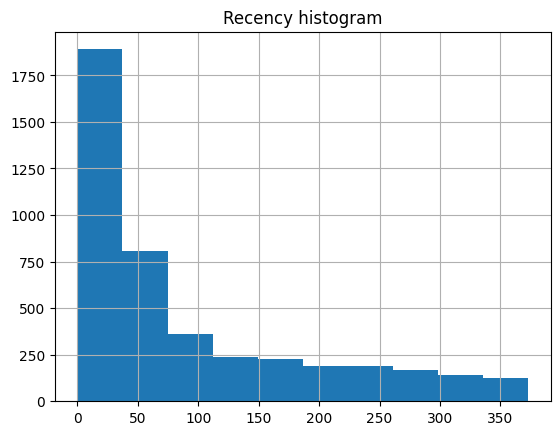

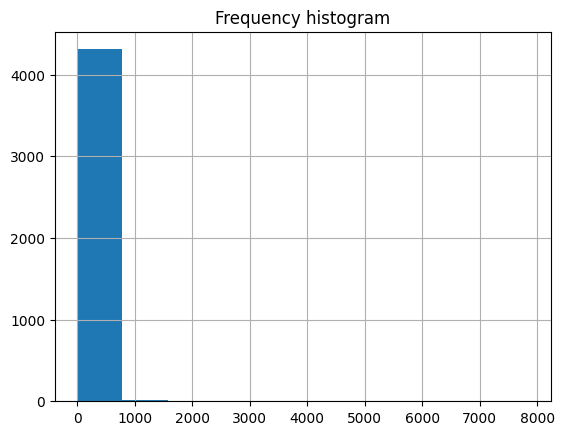

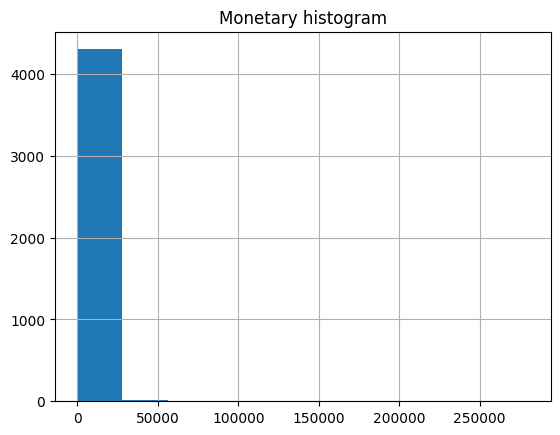

In [213]:
# step 9: Plot histograms of each field
customer_df['Recency'].hist()
plt.title('Recency histogram')
plt.show()

customer_df['Frequency'].hist()
plt.title('Frequency histogram')
plt.show()

customer_df['Monetary'].hist()
plt.title('Monetary histogram')
plt.show()

PROCESSING DATA

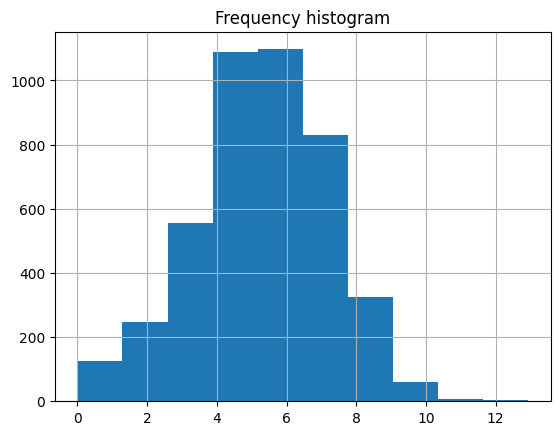

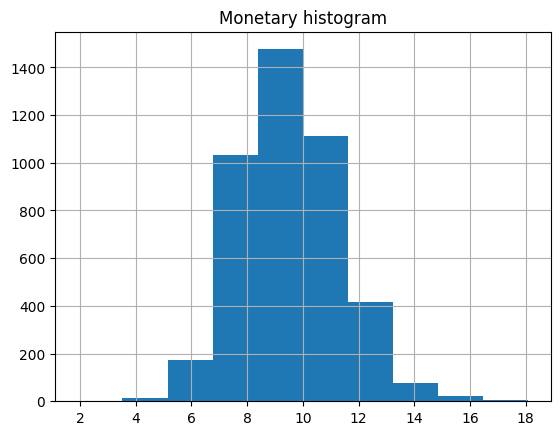

In [214]:
# step 10: Apply logarithmic transformation to correct skewness and ensure a more even distribution
customer_df_prep = customer_df[['Recency','Frequency','Monetary']].copy()

customer_df_prep['Frequency'] = np.log2(customer_df_prep['Frequency'])
customer_df_prep['Monetary'] = np.log2(customer_df_prep['Monetary'])

customer_df_prep['Frequency'].hist()
plt.title('Frequency histogram')
plt.show()

customer_df_prep['Monetary'].hist()
plt.title('Monetary histogram')
plt.show()

In [215]:
# step 11: Normalize the data using MinMaxScaler to ensure all features are on the same scale.
scaler = MinMaxScaler()
normalise_df = scaler.fit_transform(customer_df_prep)

CREATE K-MEANS CLUSTERING MODEL

In [216]:
# step 12: Create K-Means Model
kmeans_model=KMeans(n_clusters=5)
kmeans_model.fit(normalise_df)
customer_df['Cluster'] = kmeans_model.predict(normalise_df)
customer_df.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,3
12347.0,1,182,4310.00,2
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,2
12350.0,309,17,334.40,3


EVALUATE K-MEANS MODEL PERFORMANCE USING INERTIA AND ELBOW PLOT

In [217]:
# step 13: Calculate intertia of K-Means model.
print('inertia:',f'{kmeans_model.inertia_:,}')

inertia: 89.49577404301812


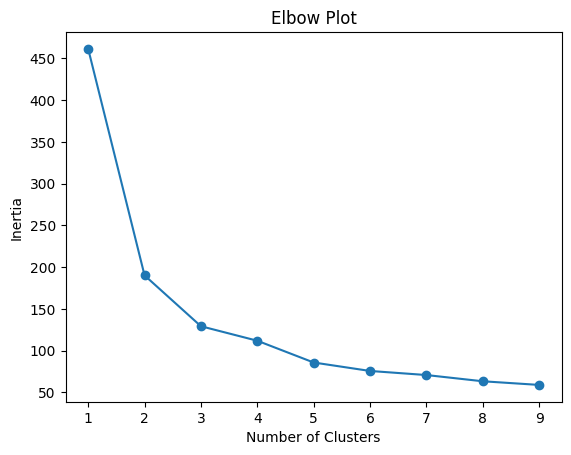

In [218]:
# step 14: Find the optimal number of clusters using the Elbow Plot.
inertias = []
cluster_range = range(1, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalise_df)
    inertias.append(kmeans.inertia_)
plt.plot(cluster_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

EVALUATE K-MEANS MODEL PERFORMANCE BY PERFORMING SILHOUETTE ANALYSIS

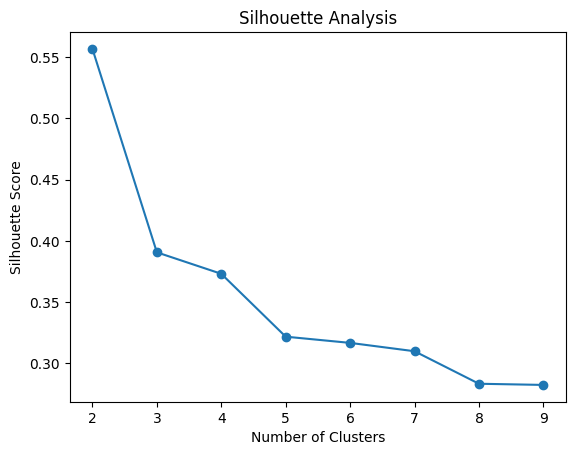

Number of clusters: 2, Silhouette Score: 0.55683938593003
Number of clusters: 3, Silhouette Score: 0.39060350504370983
Number of clusters: 4, Silhouette Score: 0.37305460215583613
Number of clusters: 5, Silhouette Score: 0.3216791601629397
Number of clusters: 6, Silhouette Score: 0.31660019098848113
Number of clusters: 7, Silhouette Score: 0.3097759866582157
Number of clusters: 8, Silhouette Score: 0.28320823092203795
Number of clusters: 9, Silhouette Score: 0.2822504635928253


In [219]:
# step 16: Find the optimal number of clusters using Silhouette Analysis.
silhouette_scores = []
cluster_range = range(2, 10)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(normalise_df)
    score = silhouette_score(normalise_df, labels)
    silhouette_scores.append(score)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Print the scores for each cluster count
for num_clusters, score in zip(cluster_range, silhouette_scores):
    print(f"Number of clusters: {num_clusters}, Silhouette Score: {score}")

VISUALIZING THE CLUSTER USING 3D SCATTER PLOT

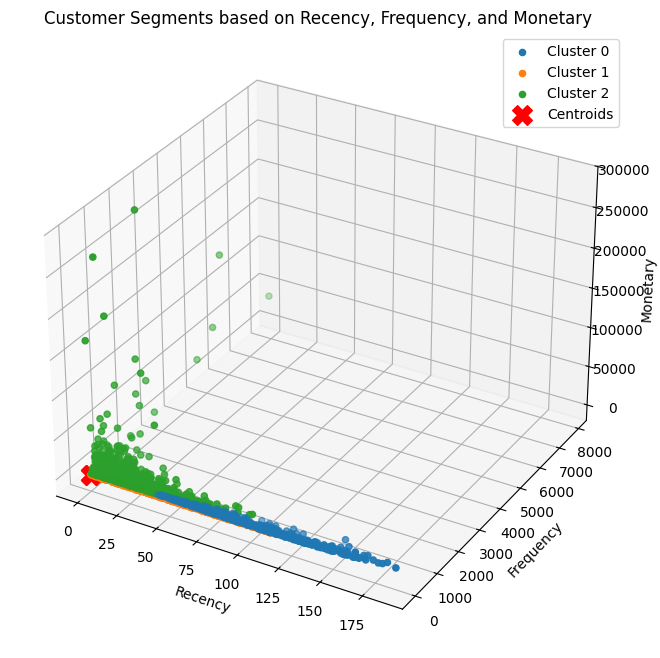

In [223]:
# Step 17: Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in range(3):  # Assuming 3 clusters based on previous analysis
    ax.scatter(
        customer_df[customer_df['Cluster'] == cluster]['Recency'],
        customer_df[customer_df['Cluster'] == cluster]['Frequency'],
        customer_df[customer_df['Cluster'] == cluster]['Monetary'],
        label=f'Cluster {cluster}'
    )

# Plot cluster centers
centers = kmeans_model.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

ax.set_title('Customer Segments based on Recency, Frequency, and Monetary')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()


### Cluster Characteristics and Recomendation Strategies:

#### Cluster 0:
- **Recency**: Not recent purchases.
- **Frequency**: Low frequency.
- **Monetary**: Low spending.
- **Strategy**:
  - **Reactivation Campaigns**: Target these customers with special discounts and offers to bring them back.
  - **Feedback Collection**: Conduct surveys to understand their inactivity and address any concerns or issues.
  - **Win-Back Strategies**: Implement win-back strategies, such as exclusive offers and limited-time promotions, to incentivize them to return and make purchases.

#### Cluster 1:
- **Recency**: Recent purchases.
- **Frequency**: Low frequency.
- **Monetary**: Low spending.
- **Strategy**:
  - **Re-engagement Campaigns**: Personalized offers and promotions can help encourage more frequent purchases.
  - **Loyalty Programs**: Implement a loyalty program to reward their engagement and increase their frequency and spending.
  - **Educational Content**: Provide information on new products or services to spark interest and drive more purchases.

#### Cluster 2:
- **Recency**: Recent purchases.
- **Frequency**: Low frequency.
- **Monetary**: Moderate to high spending.
- **Strategy**:
  - **Personalized Offers**: Send personalized offers and promotions to encourage more frequent purchases.
  - **Loyalty Programs**: Implement a loyalty program to reward their spending and increase their frequency, highlighting exclusive benefits and rewards.
  - **Upselling and Cross-selling**: Promote complementary products and higher-value items to maximize their spending.

These targeted strategies will help us optimize customer engagement and drive better business outcomes for each cluster.
